## 1 Autoencoder

In [8]:
import warnings
warnings.filterwarnings("ignore")
from keras.layers import Input, Dense,Conv1D, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dropout, Reshape, Embedding, LSTM, GlobalMaxPooling1D
from keras.models import Model
from keras.models import Sequential
from keras import backend as K
from keras import utils, optimizers
from keras.utils.np_utils import to_categorical
from keras.datasets import fashion_mnist
import numpy as np
from keras.callbacks import TensorBoard
import matplotlib.pyplot as plt
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.optimizers import SGD, RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
#import cv2
import pandas as pd
import requests
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

In [9]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

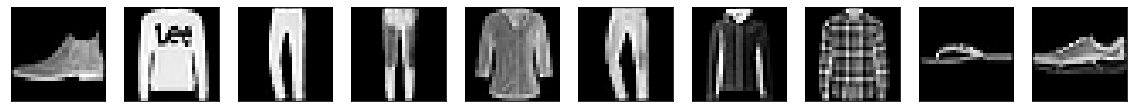

In [10]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [11]:
input_img = Input(shape=(28, 28, 1))

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)


x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [5]:
autoencoder.fit(x_train, x_train,
                epochs=10,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 75s 1ms/step - loss: 0.3569 - val_loss: 0.3227
Epoch 2/10
60000/60000 [==============================] - 84s 1ms/step - loss: 0.3083 - val_loss: 0.3008
Epoch 3/10
60000/60000 [==============================] - 83s 1ms/step - loss: 0.2993 - val_loss: 0.3024
Epoch 4/10
60000/60000 [==============================] - 84s 1ms/step - loss: 0.2944 - val_loss: 0.2958
Epoch 5/10
60000/60000 [==============================] - 83s 1ms/step - loss: 0.2913 - val_loss: 0.2913
Epoch 6/10
60000/60000 [==============================] - 84s 1ms/step - loss: 0.2890 - val_loss: 0.2893
Epoch 7/10
60000/60000 [==============================] - 83s 1ms/step - loss: 0.2869 - val_loss: 0.2879
Epoch 8/10
60000/60000 [==============================] - 82s 1ms/step - loss: 0.2853 - val_loss: 0.2861
Epoch 9/10
60000/60000 [==============================] - 82s 1ms/step - loss: 0.2839 - val_loss: 0.2910
Epoch

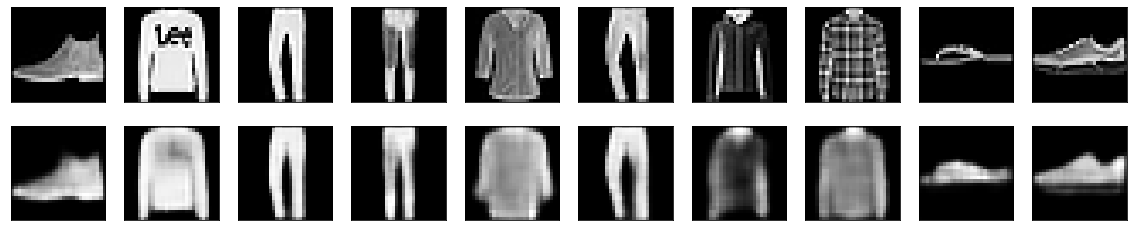

In [6]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## 2 Image Classification
### 2.1 Deep CNN

Build a deep CNN with 3 hidden layers: two 2D convolution layers, each followed by a 2 $\times$ 2 maxpooling layer and a 0.3 dropout regularization operation, and a dense layer. The two convolution layers' output is passed to a flatten layer, the dense layer with 64 units, a 0.5 dropout regularization and finally to a softmax output layer that predicts 10 categories. The two 2D convolution layers both have 3 $\times$ 3 kernels with a stride of 1. No padding is used.

In [12]:
import numpy as np
import keras
from keras import layers
from keras import models
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score

In [8]:
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [9]:
train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype('float32') / 255
test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype('float32') / 255
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

In [10]:
model = models.Sequential()
model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(28, 28, 1))) 
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))

In [11]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 11, 11, 32)        18464     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 5, 5, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 800)              

In [12]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(train_images, train_labels, epochs=5, batch_size=64)

Epoch 1/5
60000/60000 [==============================] - 49s 817us/step - loss: 0.7410 - accuracy: 0.7319
Epoch 2/5
60000/60000 [==============================] - 48s 807us/step - loss: 0.5025 - accuracy: 0.8224
Epoch 3/5
60000/60000 [==============================] - 47s 791us/step - loss: 0.4464 - accuracy: 0.8424
Epoch 4/5
60000/60000 [==============================] - 48s 807us/step - loss: 0.4196 - accuracy: 0.8508
Epoch 5/5
60000/60000 [==============================] - 49s 824us/step - loss: 0.3960 - accuracy: 0.8608


In [13]:
print("The model's accuracy score on training set:\n")
score_train = model.evaluate(train_images, train_labels, verbose=0)
print(score_train[1])
print("The model's accuracy score on test set:\n")
score_test = model.evaluate(test_images, test_labels, verbose=0)
print(score_test[1])

The model's accuracy score on training set:

0.8923333287239075
The model's accuracy score on test set:

0.8827999830245972


### 2.2 Transfer Learning

In [14]:
from keras.applications import VGG16

In [15]:
conv_base = VGG16(weights = 'imagenet', include_top = False, input_shape = (48,48,3))
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 48, 48, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0     

In [16]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation='softmax'))

# Freeze the convolutional base
print('This is the number of trainable weights before freezing the conv base:', len(model.trainable_weights))
conv_base.trainable = False
print('This is the number of trainable weights after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30
This is the number of trainable weights after freezing the conv base: 4


In [17]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                32832     
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                650       
Total params: 14,748,170
Trainable params: 33,482
Non-trainable params: 14,714,688
_________________________________________________________________


In [18]:
train_images = np.array(list(map(lambda x: np.resize(x, (48,48,3)), train_images)))
train_images.shape

(60000, 48, 48, 3)

In [19]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(train_images, train_labels, epochs=5, batch_size=64)

Epoch 1/5
60000/60000 [==============================] - 986s 16ms/step - loss: 1.1849 - accuracy: 0.5751
Epoch 2/5
60000/60000 [==============================] - 622s 10ms/step - loss: 0.8926 - accuracy: 0.6836
Epoch 3/5
60000/60000 [==============================] - 2183s 36ms/step - loss: 0.8347 - accuracy: 0.7058
Epoch 4/5
60000/60000 [==============================] - 542s 9ms/step - loss: 0.8082 - accuracy: 0.7147
Epoch 5/5
60000/60000 [==============================] - 594s 10ms/step - loss: 0.7902 - accuracy: 0.7245


In [20]:
print("The model's accuracy score on training set:\n")
score_train = model.evaluate(train_images, train_labels, verbose=0)
print(score_train[1])
print("The model's accuracy score on test set:\n")
test_images = np.array(list(map(lambda x: np.resize(x, (48,48,3)), test_images)))
score_test = model.evaluate(test_images, test_labels, verbose=0)
print(score_test[1])

The model's accuracy score on training set:

0.7514833211898804
The model's accuracy score on test set:

0.7402999997138977


## 3 Text Classification
### 3.1 RNN
Build and train a Recurrent Neural Network to solve this text classification task. You can use any type of RNN you wish (SimpleRNN, GRU, LSTM).

In [35]:
# --- Libraries ---
# - Base libs -
import os
import numpy as np
import pandas as pd

# - Data Preprocessing libs -
import nltk

# - Keras libs -
from keras.models import Sequential
from keras.layers import Dense, Embedding, SimpleRNN, LSTM, GRU, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from keras.utils import plot_model
from keras.utils.vis_utils import model_to_dot
from keras.callbacks import TensorBoard, ModelCheckpoint

# -Plot libs-
import matplotlib.pyplot as plt
from IPython.display import SVG, display
#%matplotlib inline

# -- ROC libs --
from sklearn.metrics import roc_curve, auc

In [36]:
text_data = pd.read_csv('tweets_with_labels.csv',sep='\t')

In [37]:
text_data.head()

,id,tweet,k1,k2,k3,k4,k5,k6,k7,k8,k9,k10,k11,k12,k13,k14,k15
0,1,Jazz for a Rainy Afternoon: {link},0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.000,1.0,0.0,0.0,0.000,0.0,0.0
1,2,RT: @mention: I love rainy days.,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.000,1.0,0.0,0.0,0.000,0.0,0.0
2,3,Good Morning Chicago! Time to kick the Windy C...,0.0,0.0,0.0,0.0,0.0,0.0,1.000,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.0
3,6,Preach lol! :) RT @mention: #alliwantis this t...,0.0,0.0,0.0,0.0,0.0,0.0,0.604,0.0,0.196,0.0,0.0,0.0,0.201,0.0,0.0
4,9,@mention good morning sunshine,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.000,0.0,0.0,0.0,1.000,0.0,0.0


In [38]:
## process the tweets
import string
def process_tweets(tweets):
    tweets_clean=[]

    for tweet in tweets:

        # Process text
        tokens = nltk.casual_tokenize(tweet)

        # Remove URL
        tokens =[term for term in tokens if not term.startswith('{') ]

        # Remove profiles
        tokens1 = [term for term in tokens if not term.startswith('@')]

        # Remove punctuation
        punctuation = list(string.punctuation)
        tokens2 = [term for term in tokens1 if term not in punctuation]

        # Remove hashtags
        tokens3 = [term for term in tokens2 if not term.startswith('#')]
        
        if tokens3 != []:
            
            sentence3 = ' '.join(tokens3)
        else:
            sentence3 = 'no words left'
        
        tweets_clean.append(sentence3)
    
    return tweets_clean

In [39]:
text_data['tweet_clean'] = process_tweets(text_data['tweet'])

In [40]:
## get the clean tweets
text_clean = text_data[text_data['tweet_clean']!= 'no words left']

In [41]:
text_clean.head(5)

,id,tweet,k1,k2,k3,k4,k5,k6,k7,k8,k9,k10,k11,k12,k13,k14,k15,tweet_clean
0,1,Jazz for a Rainy Afternoon: {link},0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.000,1.0,0.0,0.0,0.000,0.0,0.0,Jazz for a Rainy Afternoon link
1,2,RT: @mention: I love rainy days.,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.000,1.0,0.0,0.0,0.000,0.0,0.0,RT I love rainy days
2,3,Good Morning Chicago! Time to kick the Windy C...,0.0,0.0,0.0,0.0,0.0,0.0,1.000,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.0,Good Morning Chicago Time to kick the Windy Ci...
3,6,Preach lol! :) RT @mention: #alliwantis this t...,0.0,0.0,0.0,0.0,0.0,0.0,0.604,0.0,0.196,0.0,0.0,0.0,0.201,0.0,0.0,Preach lol :) RT this type of weather all the ...
4,9,@mention good morning sunshine,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.000,0.0,0.0,0.0,1.000,0.0,0.0,good morning sunshine


In [42]:
text = text_clean['tweet_clean']
label =  text_clean.iloc[:,2:-1].values

In [28]:
## split data
text_train,text_test,label_train,label_test = train_test_split(text,label,test_size=0.2,random_state=12)

MAX_NUM_WORDS = 500 
MAX_SEQUENCE_LENGTH = 50 

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(text_train)
train_sequences = tokenizer.texts_to_sequences(text_train) 
test_sequences = tokenizer.texts_to_sequences(text_test)

text_train_2 = pad_sequences(train_sequences,maxlen=MAX_SEQUENCE_LENGTH)
text_test_2 = pad_sequences(test_sequences,maxlen=MAX_SEQUENCE_LENGTH)

## split train data into training and validation
train_text = text_train_2[:50000]

val_text = text_train_2[50000:]

train_label = label_train[:50000]

val_label = label_train[50000:]

In [30]:
## make model of LSTM
model_RNN = Sequential()
model_RNN.add(Embedding(MAX_NUM_WORDS, 64))
#model.add(SimpleRNN(32))
#model.add(GRU(32))
model_RNN.add(LSTM(32))
model_RNN.add(Dense(15, activation ='softmax'))
model_RNN.compile(optimizer = 'rmsprop',
             loss = 'categorical_crossentropy',
             metrics=['acc'])
rnn_history = model_RNN.fit(train_text,train_label,epochs = 10,validation_data = (val_text, val_label), batch_size = 64,verbose=1)

Train on 50000 samples, validate on 12320 samples
Epoch 1/10
50000/50000 [==============================] - 27s 536us/step - loss: 2.0129 - acc: 0.5776 - val_loss: 1.6439 - val_acc: 0.7278
Epoch 2/10
50000/50000 [==============================] - 27s 537us/step - loss: 1.5214 - acc: 0.7697 - val_loss: 1.5343 - val_acc: 0.7515
Epoch 3/10
50000/50000 [==============================] - 20s 408us/step - loss: 1.5022 - acc: 0.7723 - val_loss: 1.5316 - val_acc: 0.7644
Epoch 4/10
50000/50000 [==============================] - 21s 415us/step - loss: 1.5127 - acc: 0.7802 - val_loss: 1.5363 - val_acc: 0.7678
Epoch 5/10
50000/50000 [==============================] - 22s 434us/step - loss: 1.5277 - acc: 0.7831 - val_loss: 1.5415 - val_acc: 0.7735
Epoch 6/10
50000/50000 [==============================] - 23s 456us/step - loss: 1.5459 - acc: 0.7825 - val_loss: 1.5756 - val_acc: 0.7726
Epoch 7/10
50000/50000 [==============================] - 24s 487us/step - loss: 1.5586 - acc: 0.7823 - val_loss: 1.

In [43]:
RNN_loss, RNN_acc = model_RNN.evaluate(text_test_2, label_test)
# Test Error
print('The loss of test data is:', RNN_loss)
print('The accuray of test data is: %.2f%%' % (RNN_acc*100))

15580/15580 [==============================] - 4s 241us/step
The loss of test data is: 1.6019382168300957
The accuray of test data is: 76.42%


### 3.2 CNN
Build and train a 1D CNN for this text classification task. We recommend you do a character-level convolution (with character embeddings).

In [56]:
model_CNN = Sequential()
model_CNN.add(Embedding(MAX_NUM_WORDS,64))
model_CNN.add(Conv1D(64, kernel_size = 3,padding='valid',activation='relu',strides=1))
model_CNN.add(GlobalMaxPooling1D())
model_CNN.add(Dropout(0.2))
model_CNN.add(Dense(64,activation='relu'))
model_CNN.add(Dense(15,activation='softmax'))
model_CNN.compile(optimizer = 'adam',
             loss = 'categorical_crossentropy',
             metrics=['acc'])
cnn_history = model_CNN.fit(train_text,train_label,epochs = 10,validation_data = (val_text, val_label), batch_size = 64,verbose=1)

Train on 50000 samples, validate on 12320 samples
Epoch 1/10
50000/50000 [==============================] - 6s 121us/step - loss: 216.5647 - acc: 0.2697 - val_loss: 1120.8352 - val_acc: 0.1280
Epoch 2/10
50000/50000 [==============================] - 6s 126us/step - loss: 4097.8579 - acc: 0.1460 - val_loss: 10429.6638 - val_acc: 0.1096
Epoch 3/10
50000/50000 [==============================] - 6s 120us/step - loss: 18316.1537 - acc: 0.1478 - val_loss: 29527.8303 - val_acc: 0.0319
Epoch 4/10
50000/50000 [==============================] - 6s 123us/step - loss: 41304.7889 - acc: 0.1441 - val_loss: 88664.8865 - val_acc: 0.0319
Epoch 5/10
50000/50000 [==============================] - 6s 125us/step - loss: 85597.0531 - acc: 0.1435 - val_loss: 86511.0665 - val_acc: 0.0459
Epoch 6/10
50000/50000 [==============================] - 6s 128us/step - loss: 130433.7754 - acc: 0.1421 - val_loss: 202258.2743 - val_acc: 0.0145
Epoch 7/10
50000/50000 [==============================] - 6s 129us/step - lo

In [57]:
CNN_loss, CNN_acc = model_CNN.evaluate(text_test_2, label_test)
# Test Error
print('The loss of test data is:', CNN_loss)
print('The accuray of test data is: %.2f%%' % (CNN_acc*100))

15580/15580 [==============================] - 1s 63us/step
The loss of test data is: 408536.2221277279
The accuray of test data is: 9.26%


### 3.3
Be sure to directly compare your two methods with an ROC curve or similar validation method. Don't forget to create a train-test split.

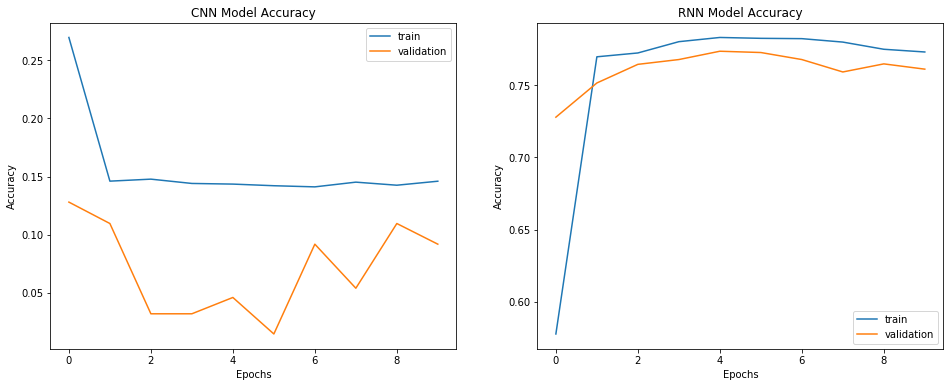

In [58]:
# Plot the results
plt.figure(figsize=(16,6))
plt.subplot(1, 2, 1)
plt.plot(cnn_history.history['acc'])
plt.plot(cnn_history.history['val_acc'])
plt.title('CNN Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])

plt.subplot(1, 2, 2)
plt.plot(rnn_history.history['acc'])
plt.plot(rnn_history.history['val_acc'])
plt.title('RNN Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

The result of two models are quite different.
The test accuracy for CNN is 9.26% while for RNN is 76.42%.